#Temporary

In [134]:
#Utilities
#!pip install gwpy --quiet
#!pip install facenet-pytorch --quiet
#!pip install seaborn



/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.5 MB/s eta 0:00:00a 0:00:01


# Importing libraries

In [135]:
# Dados
from pathlib import Path
import urllib.request
import zipfile


#data processing
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import v2
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter




#data analisis
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score,
                             recall_score, f1_score)

#!git clone https://github.com/ox-vgg/vgg_face2.git



In [ ]:
# setting device 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Parameters

In [ ]:
data_dir = "./images/train"
path_tensor = './tensor_images/'


learning_rate = 0.001
epochs = 50
size_img = 160      #facenet-pytorch vggface2 size
margin = 20
batch_size = 32
workers = 2

# Downloading Dataset

In [ ]:


def downloading_dataset():
    if not Path("./images").exists():
        Path("./images").mkdir()

    # Baixando o arquivo zip do repositório
    !wget https://github.com/mm909/Kaggle-Autism/archive/refs/heads/master.zip
    
    # Extraindo o conteúdo da pasta cleanData
    !unzip master.zip Kaggle-Autism-master/data/* -d ./images/ > /dev/null 2>&1
    
    # Movendo o conteúdo para o diretório desejado
    !mv ./images/Kaggle-Autism-master/data/* ./images/ > /dev/null 2>&1
    
    # Removendo arquivos desnecessários
    !rm -r ./Kaggle-Autism-master > /dev/null 2>&1
    !rm master.zip > /dev/null 2>&1


# Preprocessing Data

## Resizing and normalizing

In [ ]:
!rm -r tensor_images

In [ ]:
def dataset_transform_and_save(path_tensor, tensor_name, transform):
  try:
    print("Tensor loaded")
    return  torch.load(path_tensor + tensor_name)
  except FileNotFoundError:
    os.makedirs(path_tensor, exist_ok=True)
    print("Directory created")

  ds = datasets.ImageFolder(root=data_dir, transform=transform)

  try:
    torch.save(dataset, path_tensor + tensor_name)
    print("tensor saved")
  except Exception:
    print("tensor not saved")

  return ds

In [ ]:
def calculate_mean_and_std():
    data_mean =[]
    data_std = []
    for i, (image, label) in enumerate(initial_dataset):
        mt = torch.mean(image, dim=(1, 2))
        st = torch.std(image, dim=(1, 2))
    
        #appended to the list
        data_mean.append(mt)
        data_std.append(st)

    m = np.array(data_mean).mean(axis =0).astype("float32").tolist()
    s  = np.array(data_std).mean(axis=0).astype("float32").tolist()
    
    #saving into a csv to decresase need to future calculations
    df = pd.DataFrame({'mean': m, 'std': s})
    df.to_csv('mean_std')
    return m, s

def load_mean_std():
    if not Path("mean_std.csv").exists():
        return calculate_mean_and_std()
        
    a = pd.read_csv('mean_std')
    m = a['mean'].values
    s = a['std'].values
    return m,s

## Defining transforms

In [ ]:
initial_transform = v2.Compose([
      v2.Resize(size=(size_img, size_img)),
      v2.RandomHorizontalFlip(),
      v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
])

mean,std = load_mean_std()

data_transform = transforms.Compose([
    initial_transform,
    transforms.Normalize(mean, std),
    v2.ToDtype(torch.float32, scale=True),
])

test_transform = transforms.Compose([
    initial_transform,
    v2.ToDtype(torch.float32, scale=True),
])


## Transforming tensors

In [ ]:
resized_tensor = 'loaded_tensors_resized'
normalized_tensor = 'loaded_tensors_normalized'

initial_dataset = dataset_transform_and_save(path_tensor, resized_tensor, initial_transform)
dataset = dataset_transform_and_save(path_tensor,normalized_tensor, data_transform)

## Print batch

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers = 2,
                                         collate_fn=training.collate_pil)
dataiter = iter(dataloader)
data = next(dataiter)

image_batch, labels_batch = data

img = torchvision.utils.make_grid(image_batch)
img = np.transpose(img, (1,2,0))

plt.figure(figsize=(5,10))
plt.imshow(img)
plt.axis('off')
plt.show()

# CNN

## Loading pre-trained ai with facial recognition

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [8, 15, 30])

## Preparing data and metrics

In [100]:
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'acc': training.accuracy
}

## Training model

In [ ]:
def train():
    writer = SummaryWriter()
    writer.iteration, writer.interval = 0, 10
    
    print('\n\nInitial')
    print('-' * 10)
    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    
    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
    
        resnet.train()
        training.pass_epoch(
            resnet, loss_fn, train_loader, optimizer, scheduler,
            batch_metrics=metrics, show_running=True, device=device,
            writer=writer
        )
    
        resnet.eval()
        training.pass_epoch(
            resnet, loss_fn, val_loader,
            batch_metrics=metrics, show_running=True, device=device,
            writer=writer
        )
        
    writer.close()
    torch.save(resnet.state_dict(), 'trained_model.pth')


train()

# Evaluate

## Loading trained model

In [110]:
model = InceptionResnetV1(
    classify=True,
    pretrained=None,  # Desativar o carregamento automático de pesos pré-treinados
    num_classes=len(dataset.class_to_idx)
).to(device)
checkpoint = torch.load("trained_model.pth")

model.load_state_dict(checkpoint)
model.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

## Functions for analysis

In [119]:
from PIL import Image

photos_paths = []

def read_photos(image_folder_path, file_extension):
    photos_tensors = []
    
    files = os.listdir(image_folder_path)
    photos_end = [arquivo for arquivo in files if arquivo.lower().endswith(file_extension)]
    for photo in photos_end:
        photo_path = os.path.join(image_folder_path, photo)
        photos_paths.append(photo_path)
        img_tensor = data_transform(Image.open(photo_path)).unsqueeze(0).to(device)
        photos_tensors.append(img_tensor)
        
    return photos_tensors


def inference(input_img):
    with torch.no_grad():
        output = model(input_img)

    prob = torch.nn.functional.softmax(output[0], dim=0).cpu()
    return predict(torch.argmax(prob).item()), prob.numpy().tolist()


def predict(prob):
    return 'autistic' if prob == 0 else 'non-autistic'
def print_photos(probabilities, photo_tensor, num, mode):   
    if mode == 'tensor':
        photo = np.array(photo_tensor.to('cpu').squeeze(0))
        photo = np.transpose(photo, (1,2,0))
    else:
        photo = Image.open(photos_paths[num])
    
    plt.title(f"{probabilities[0]}\nAutistic: {probabilities[1][0]:.6f}\nNon-Autistic: {probabilities[1][1]:.6f}")
    plt.imshow(photo)
    plt.axis('off')


## Infer and save individual image batch

In [ ]:
def test_and_save_img(path_test_photos,file_name,file_extension,mode):
    test_photos = read_photos(path_test_photos,file_extension)

    for h, photo_tensor in enumerate(test_photos):
        if h >= 18:
            break
        result = inference(photo_tensor)
        test_data.append(result)
        print_photos(result,photo_tensor,h, mode)
        plt.savefig(path_test_photos + f'/{file_name}{h}', dpi = 100)
        plt.show()


test_data = []
test_and_save_img('path', 'new_file_name', 'jpeg', 'tensor') ##path, save_name, extension, mode: (tensor, photo)

## Test inference

In [145]:
autistic = read_photos('./images/test/Autistic','jpg')
non_autistic = read_photos('./images/test/Non_Autistic','jpg')


def evaluate(eval_tensor, label):
    global true_autistic, true_non_autistic, false_non_autistic, false_autistic
    for j, photo_tensors in enumerate(eval_tensor):
        if j>= 500:
            break
        result1 = inference(photo_tensors)
        gen_data.append(result1)
        if result1[0] == 'autistic' and label == 'autistic':
            true_autistic = true_autistic + 1
        elif result1[0] == 'non-autistic' and label == 'non-autistic':
            true_non_autistic = true_non_autistic + 1
        elif result1[0] == 'non-autistic':
            false_non_autistic = false_non_autistic + 1
        else:
            false_autistic = false_autistic + 1
            
            
gen_data = []

true_autistic = 0
true_non_autistic = 0
false_non_autistic = 0
false_autistic = 0

evaluate(autistic, 'autistic')
evaluate(non_autistic, 'non-autistic')


labels = [item[0] for item in gen_data]
au_prob = [item[1][0] for item in gen_data]
non_au_prob = [item[1][1] for item in gen_data]

# Criar o DataFrame
gen_df = pd.DataFrame({'Label': labels, 'Au prob': au_prob, 'Non-Au prob': non_au_prob})
gen_df.to_csv('generate_test_data')

gen_df


,Label,Au prob,Non-Au prob
0,autistic,0.926708,0.073292
1,autistic,0.945626,0.054374
2,autistic,0.858732,0.141268
3,non-autistic,0.085972,0.914028
4,non-autistic,0.159772,0.840228
...,...,...,...
275,non-autistic,0.005912,0.994089
276,autistic,0.913286,0.086714
277,non-autistic,0.211696,0.788304
278,non-autistic,0.055580,0.944420


In [ ]:
total_autistic = false_autistic + true_autistic
total_non_autistic = false_non_autistic + true_non_autistic
total = total_autistic + total_non_autistic

FN = false_autistic + false_non_autistic 
TP = true_autistic + true_non_autistic
hit_rate = TP/total
miss_rate = FN/total

results_dic = {
    'true_autistic': [true_autistic],
    'true_non_autistic': [true_non_autistic],
    'total_autistic': [total_autistic],
    'false_non_autistic': [false_non_autistic],
    'false_autistic': [false_autistic],
    'total': [total],
    'TP': [TP],
    'FN': [FN],
    'hit_rate': [hit_rate],
    'miss_rate': [miss_rate],
}

results_df = pd.DataFrame(results_dic)
results_df= results_df.T.reset_index()
results_df.columns = ['Name', 'Value']
results_df.to_csv('test_results')

print(f"hit: {TP}  miss: {FN}    |   total: {total}\n")
print(f"autistic hit: {true_autistic}   autistic miss: {false_non_autistic}    |   total: {total/2}\n")
print(f"non autistic hit: {true_non_autistic}   non autistic miss: {false_autistic}    |   total: {total/2}\n")
print(f"hit rate: {hit_rate}  miss rate: {miss_rate}")

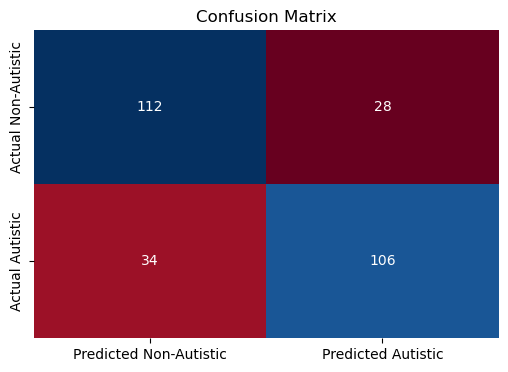

In [139]:
# Criar a matriz de confusão
conf_matrix_data = [[true_non_autistic, false_autistic],
                    [false_non_autistic, true_autistic]]

# Criar um DataFrame a partir da matriz de confusão
conf_matrix_df = pd.DataFrame(conf_matrix_data, columns=['Predicted Non-Autistic', 'Predicted Autistic'],
                               index=['Actual Non-Autistic', 'Actual Autistic'])

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='RdBu', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [140]:
#other metrics
accuracy = (true_autistic + true_non_autistic) / total
precision = true_autistic / (true_autistic + false_autistic)
recall = true_autistic / (true_autistic + false_non_autistic)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Exibir métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.78
Precision: 0.79
Recall: 0.76
F1 Score: 0.77
